# Imports and Constants

In [1]:
import math
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score


RANDOM_SEED = 1936

# Implementation

## Utility / Plotting Functions

In [2]:
def plot_images(arr, titles = None, n_col = 6):

    # all images are flattened, so we must unpack them
    
    if arr.ndim == 1:
        # a single greyscale image
        arr = arr.reshape((int(math.sqrt(arr.shape[0])), int(math.sqrt(arr.shape[0]))))
        plt.imshow(arr, cmap="gray")
        
    elif arr.ndim == 2:
        if arr.shape[1] == 3:
            # a single color image
            arr = arr.reshape((int(math.sqrt(arr.shape[0])), int(math.sqrt(arr.shape[0])), 3))
            plt.imshow(arr)
        else:
            # multiple greyscale images
            arr = arr.reshape((arr.shape[0], int(math.sqrt(arr.shape[1])), int(math.sqrt(arr.shape[1]))))
            plot_portraits(arr, titles, color=False, n_col = n_col)
            
    elif arr.ndim == 3:
        # multiple color images
        arr = arr.reshape((arr.shape[0], int(math.sqrt(arr.shape[1])), int(math.sqrt(arr.shape[1])), 3))
        plot_portraits(arr, titles, color=True, n_col = n_col)
        
    else:
        raise RuntimeError("I have no idea what you want me to do.")
        
def plot_portraits(images, titles = None, color = False, n_col = 6):
    """
    Code adapted from source [7]
    """
    
    n_row = math.ceil(images.shape[0] / n_col)
    
    plt.figure(figsize=(2.2 * n_col, 2.2 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.20)
    
    for i in range(images.shape[0]):
        plt.subplot(n_row, n_col, i + 1)
        
        if color:
            plt.imshow(images[i])
        else:
            plt.imshow(images[i], cmap="gray")
        
        if titles is not None:
            plt.title(titles[i])
        
        plt.xticks(())
        plt.yticks(())

## Data Import

In [3]:
def load_data(dir, num_images, shuffle=False, random_state = 42):
    image_file_names = os.listdir(dir)[0:num_images]
    image_paths = [dir + "/" + file_name for file_name in image_file_names]

    images = np.array([plt.imread(path) for path in image_paths])
    image_labels = [name[:name.find('0')-1].replace("_", " ") for name in image_file_names]

    # flatten the images into vectors
    if images.ndim == 4:
        # color images
        new_shape = (images.shape[0], images.shape[1]*images.shape[2], 3)
    else:
        # greyscale images
        new_shape = (images.shape[0], images.shape[1]*images.shape[2])
    
    images = np.reshape(images, new_shape)
    image_labels = np.array(image_labels)
    
    if shuffle:
        np.random.seed(random_state)
        indecies = np.random.permutation(len(images))
        return images[indecies], image_labels[indecies]
    else:
        return images, image_labels

## Eigenfaces

In [4]:
class Eigenfaces(BaseEstimator,TransformerMixin):
    def __init__(self, num_eigenvectors = None, prop_var_retained = None):
        
        self.mean = None
        self.eigenvalues = None
        self.eigenvectors = None
        
        self.var_props = None
        self.cumu_var_props = None
        
        self.basis = None
        self.num_eigenvectors = num_eigenvectors
        self.prop_var_retained = prop_var_retained
        
    def fit(self, X, y = None):
        """
        Eigen decomposes the faces images specified by the numpy array 
        parameter X (long form: rows are observations, columns are variables)
        Computes min(M,N^2) eigenvectors / eigenvalues where
        X has M observations and N^2 dimensions
        
        The mean face vector is stored in self.mean
        The eigenfaces are stored in self.eigenvectors
        The eigenvalues are stored in self.eigenvalues
        
        The proportion of variance each eigenvector explains is stored in self.var_props
        The cumulative propoprtions of variance are stored in self.cumu_var_props
        
        The basis is set using a call to Eigenvaces._set_basis() which uses class parameters, or
        all of the eigenvectors if no parameters were given.
        """
        
        # mean center the data
        mean = np.mean(X, axis=0)
        X_bar = X - mean
        
        # put into wide form for calculations
        X_bar = X_bar.T
        
        n_squared = X_bar.shape[0] # number of dimensions of each image
        m = X_bar.shape[1] # number of images
        
        if n_squared < m:
            S = np.cov(X_bar) # an (n_squared x n_squred) matrix, same as np.cov(X)
            values, vectors = np.linalg.eig(S)
            
        else:
            A = math.sqrt(1/(m-1)) * X_bar
            ATA = np.matmul(A.T, A) # an (m x m) matrix
            
            values, vectors = np.linalg.eig(ATA)
            
            vectors = np.matmul(A, vectors)
            
        # put the eigenvectors into long form
        vectors = vectors.T
        
        # sort by eignevalue descending
        values, vectors = zip(*sorted(zip(values, vectors), reverse=True))
        values = np.array(values)
        vectors = np.array(vectors)
        
        # normalize vectors to be unit length
        norms = np.linalg.norm(vectors, axis=1)
        norms = norms.reshape(norms.shape[0],1)
        vectors = vectors / norms
        
        self.mean = mean
        self.eigenvalues = values
        self.eigenvectors = vectors
        
        self.var_props = self.eigenvalues / np.sum(self.eigenvalues)
        self.cumu_var_props = np.cumsum(self.var_props)
        
        # an orthonormal basis
        # basis is set using constructor parameters, or all eigenvectors if no parameters given
        if self.num_eigenvectors is None and self.prop_var_retained is None:
            self._set_basis(prop_var_retained = 1.0)
        else:
            self._set_basis(self.num_eigenvectors, self.prop_var_retained)
        
        return
    
    def _set_basis(self, num_eigenvectors = None, prop_var_retained = None):
        """
        Sets the basis for the face space.  This can be done in one of two methods, 
        listed below in order of priority.  self.basis is an array of indecies into self.eigenvectors.
        
        If num_eigenvectors is specified, the basis is just the first num_eigenvectors eigenvectors
        stored in self.eigenvectors.
        
        If prop_variance is specified, the basis will be made up of enough eigenvectors to meet the
        specified proportion of total variance of the original images.
        """
        
        if self.eigenvectors is None:
            raise RuntimeError("Eigenfaces haven't been calculated yet! Run Eigenfaces.dempose() to calculate eigenfaces.")
        
        if num_eigenvectors is not None:
            if num_eigenvectors <= 0 or num_eigenvectors > len(self.eigenvectors):
                raise ValueError("At least 1 and no more than " + str(len(self.eigenvectors)) + " eigenvectors " \
                "can be chosen from self.eigenvectors.")
            
            self.basis = np.arange(0,num_eigenvectors)
            
        elif prop_var_retained is not None:
            if prop_var_retained < 0 or prop_var_retained > 1:
                raise ValueError("Specified proportion of variance is not in the range [0,1].")
            elif prop_var_retained == 1:
                self.basis = np.arange(0,len(self.eigenvalues))
            else:
                index = np.where(self.cumu_var_props > prop_var_retained)[0][0]
                self.basis = np.arange(0, index+1)
            
        else:
            raise ValueError("Please specify at least one method for choosing a basis.")        
            
    def transform(self, X, y = None):
        """
        Calculates the scalars used in linear combinations of the self.basis
        vectors to create a projection of the column vetors of X onto self.basis
        
        X is in long form with observations as rows and dimensions as columns
        """
        
        if self.basis is None:
            raise RuntimeError("Basis hasn't been calculated yet!  Run Eigenfaces.fit() to calculate eigenvectors")
        
        return np.matmul(X, self.eigenvectors[self.basis].T)
    
    def reconstruct(self, projection_scalars):
        """
        Reconstructs an array of images using self.basis and an
        array of the scalars used in a linear combination of the 
        basis vectors.
        
        The numpy array projection is in long form with observations
        as rows and linear combination scalars accross columns
        """
        
        if self.basis is None:
            raise RuntimeError("Basis hasn't been calculated yet!  Run Eigenfaces.fit() to calculate eigenvectors,'\
                                ' and optionally run Eigenfaces.set_basis() to subset those basis vectors.")
        
        return np.matmul(projection_scalars, self.eigenvectors[self.basis])
    
    def project(self, X):
        """
        Projects the images specified by the numpy array parameter X
        (long form: rows are observations, columns are variables)
        onto the face space, the space spanned by the eigenvectors 
        stored in self.basis.  This is the transforming part.  The projected
        vectors are returned.
        """
        
        return self.reconstruct(self.transform(X))
    
    def fit_transform(self, X, y = None):
        """
        Calculates eigenvectors / eigenvalues by calling self.fit(X)
        This is the fitting part.
        
        Projects the images specified by the numpy array parameter X
        (long form: rows are observations, columns are variables)
        onto the face space, the space spanned by the eigenvectors 
        stored in self.basis.  This is the transforming part.  The projected
        vectors are returned.
        """
        
        self.fit(X, y)
        
        return self.transform(X, y)

# Application / Demonstration

## Data Import

The dataset used in this project is the LFWcrop Face Dataset.  The LFWcrop is a cropped version of the Labeled Faces in the Wild dataset, which is a collection of labeled face images in both color and greyscale.  The cropped version crops the images to just contain the faces, and no background.  There are 13,233 images of 64x64 pixels each.  Some people included in the dataset have more than one image associated with them **[[1]](#sources)**.  Shown below is code to import the dataset, and a description of the distribution of the number of images per person.  

In [5]:
num_images = 13233 #load all images

X, y = load_data("datasets/lfwcrop_grey/faces", num_images, shuffle=True, random_state = RANDOM_SEED)

X.shape, y.shape

((13233, 4096), (13233,))

In [6]:
pd.Series(y).value_counts().describe()

count    5749.000000
mean        2.301792
std         9.016410
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       530.000000
dtype: float64

There are 5749 different classes (people) included in the dataset.  On average, each person has 2.3 images associated with them.  There's one person who has 530 images of themself in the dataset.

## Eigenface Decomposition

### Principal Component Analysis

The process of creating eigenfaces is a the use of a statistical method called **Principal Component Analysis** (PCA) on a dataset of face images.  Each observation in the dataset is a different face, and each variable is the value that a given pixel takes on.  For color images, each pixel has 3 values (red, green, and blue), but for greyscale images, there is only 1 value.  In this project, greyscale images are used.  

Principal Component Analysis is the process of taking data, and writing it in a more efficient representation.  Let each image be $N\times N$ pixels.  This means that we can flatten the image's pixels to be an $N^2 \times 1$ vector (a row vector here). We can think of our data as a collection of points $\mathbf x_i$ ($i=1...M$) in the $N^2$ dimensional space ${\rm I\!R}^{N^2}$. Let $X$ be our dataset with $M$ observations.  We can write $X$ as an $N^2 \times M$ matrix **[[2]](#sources)**.

<br>

$$\textbf{Flattening Images}\;\;\;\;\;\;\mathbf x_i = \begin{bmatrix}x_{11} & ... & x_{1N} \\ ... & ... & ... \\x_{N1} & ... & x_{NN} \end{bmatrix} \longrightarrow \begin{bmatrix}x_{11} \\ x_{12} \\ x_{13} \\ ... \\ x_{NN}\end{bmatrix}$$

<br>

$$\textbf{Data Matrix}\;\;\;\;\;\;\underset{(N^2 \times M)}{X}=\begin{bmatrix}\mathbf x_{1} & \mathbf x_{2} & \mathbf x_{3} & ... & \mathbf x_{M}\end{bmatrix}=\begin{bmatrix}x_{11} & x_{12} & ... & x_{1M}\\ x_{21} & x_{22} & ... & x_{2M}\\  ... & ... & ... & ... \\ x_{N^21} & x_{N^22} & ... & x_{N^2M}\\\end{bmatrix}$$

<br>

PCA considers the **covaraince** matrix of $X$.  The covariance matrix is a multi-dimensional generalization of the variance statistic, and describes how data (vectors) are spread out in higher dimensional space.  In a dataset with $N^2$ dimensions, the covariance matrix $S$ will be of size $N^2 \times N^2$.  $S_{ij}$ represents the covariance between the $i^{th}$ and $j^{th}$ variables.  When $i=j$, $S_{ij}$ represents the variance of the $i^{th}$ variable.  To calculate $S$, we center our data $X$ by subtracting its row-wise mean vector $\mu$, multiply by the transpose, and divide by the corresponding degrees of freedom ($M - 1$) **[[2]](#sources)**.

<br>

$$\textbf{Mean Vector}\;\;\;\;\;\;\underset{(N^2 \times 1)}{\mu} = \frac{1}{M} \; \underset{(N^2 \times M)}{X} \underset{(M \times 1)}{\mathbf 1} = \frac{1}{M} \; \begin{bmatrix}x_{11} & x_{12} & ... & x_{1M}\\ x_{21} & x_{22} & ... & x_{2M}\\  ... & ... & ... & ... \\ x_{N^21} & x_{N^22} & ... & x_{N^2M}\\\end{bmatrix} \begin{bmatrix}1 \\ 1 \\ ... \\ 1\end{bmatrix} = \begin{bmatrix}\bar{x_1} \\ \bar{x_2} \\ ... \\ \bar{x}_{N^2}\end{bmatrix}$$

<br>

$$\textbf{Mean Centered Data}\;\;\;\;\;\;\underset{(N^2 \times M)}{\bar X} = \underset{(N^2 \times M)}{X} - \underset{(N^2 \times M)}{\begin{bmatrix}\mu & ... & \mu \end{bmatrix}}$$

<br>

$$\textbf{Covariance Matrix}\;\;\;\;\;\;\underset{(N^2 \times N^2)}{S}=\frac{1}{M-1} \; \underset{(N^2 \times M)}{\bar{X}} \underset{(M \times N^2)}{\bar{X}^T}$$

<br>

Beacuse the coviarnace matrix is square, we can interpret it as an operator on ${\rm I\!R}^{N^2}$.  In other words, $S \in \mathcal{L}({\rm I\!R}^{N^2})$.  Consider the eigenvectors, $e_1, ... , e_{N^2}$, and eigenvalues, $\lambda_1, ... , \lambda_{N^2}$, of $S$. Because $S$ is a covariance matrix, it is guaranteed to be positive, meaning that its eigenvalues are real and positive **[[3]](#sources)**.  This corresponds to stretching space by positive scalars.  These eigenvectors also form an orthonormal basis of ${\rm I\!R}^{N^2}$, which means that their inner products are all 0, and there is no correlation between the eigenvectors **[[4]](#sources)**.  Because there is no correlation between the eigenvectors, each eigenvector represents unique information in the space, and therefore is the optimal basis for representing our data in ${\rm I\!R}^{N^2}$.

<br>

$$\textbf{Ordered, Positive Eigenvalues}\;\;\;\;\;\;\lambda_1 \geq ... \geq \lambda_{N^2} \geq 0$$

<br>

$$\textbf{Orthogonormal Eigenvectors}\;\;\;\;\;\;\langle\,e_i,e_j\rangle = \begin{cases} 
      0 & \text{for} \;\;i \neq j \\
      1 & \text{for} \;\;i = j 
   \end{cases}$$

<br>

We call $e_1, ... , e_{N^2}$ the **principal components** of $X$.  The eigenvalues, $\lambda_1, ... , \lambda_{N^2}$ (with multiplicity), are the **variances** of $X$ that each corresponding principal component explains **[[3]](#sources)**.  When we transform space by the operator $S$, we are essentially stretching the principal components by the variances each principal component explains. 

By ordering the eigenvectors in decreasing order of their eigenvalues and selecting the first $k$ eigenvectors, we can create a basis for a subspace of ${\rm I\!R}^{N^2}$ that maximally represents the variance of $X$ **[[3]](#sources)**.  In this application, if we plot the eigenvectors as images, they resemble faces.  Therefore, they are also refered to as **eigenfaces**.

By projecting the observations of $X$ onto the subspace spanned by our basis $e_1, ... , e_k$, we can perform dimension reduction.  Dimension reduction is an important technique used in data compression and machine learning, which are demonstrated in later sections.

### Calculating Eigenfaces

The task of calculating eigenfaces is just an eigen-decomposition of $S$, which is an $N^2 \times N^2$ matrix.  However, for very large $N^2$ (large images), this task becomes computationally infeasible.  However, we can still calculate eigenvectors of $S$ by observing properties on $S$ and $X$. 

We can define S to be a product of a matrix $A$ and its transpose $A^T$.

$$\underset{(N^2 \times N^2)}{S}=\frac{1}{M-1} \; \underset{(N^2 \times M)}{\bar{X}} \underset{(M \times N^2)}{\bar{X}^T} = \underset{(N^2 \times N^2)}{AA^T} \;\;\;\text{where}\;\;\; \underset{(N^2 \times M)}{A}=\sqrt{\frac{1}{M-1}}\underset{(N^2 \times M)}{\bar{X}}$$

Consider an eigenvalue / eigenvector pair,  $(\lambda,w)$,  of $\underset{(M \times M)}{A^TA}$.

$$A^TAw=\lambda w$$

$$AA^TAw=A\lambda w$$

$$AA^TAw=\lambda Aw$$

$$\text{Let}\;\;\;\;\;Aw=v$$

$$AA^Tv=\lambda v$$

Notice, we now have calculated an eigenvalue / eigenvector pair, $(\lambda,w)$, of $S=AA^T$, which was our original goal.  By using this technique, we see that $S$ and $A^TA$ have the same eigenvalues, and their eigenvectors are related by $Av=w$ **[[5]](#sources)**.

We can compute the eigenvectors / eigenvalues of whichever matrix is smaller, and obtain $\min(N^2, M)$ eigenvectors / eigenvalues.  Because one goal is to reduce data by retaining only the first $k$ eigenvectors, we don't need to calculate all the eigenvectors available.  Furthermore, it has been shown that using this method we can obtain the largest eigenvalues of S, which will represent the largest variances **[[2]](#sources)**.


### Note

Computer scientists and statisticians use the convention of keeping data in *long form*, which has observations spread along rows and variables spread along columns.  Linear algebra, however has the opposite convention of keeping data in *wide form*, which has variables spread along rows and observations spread along columns.  Long forms and wide forms are matrix transposes of each other.  The mathematical proofs presented have the dataset in wide form, wheras the code implementation takes data in long form, and internally transposes it into wide form for calculations.

### Demonstration

In [7]:
TRAIN_SIZE = 10000

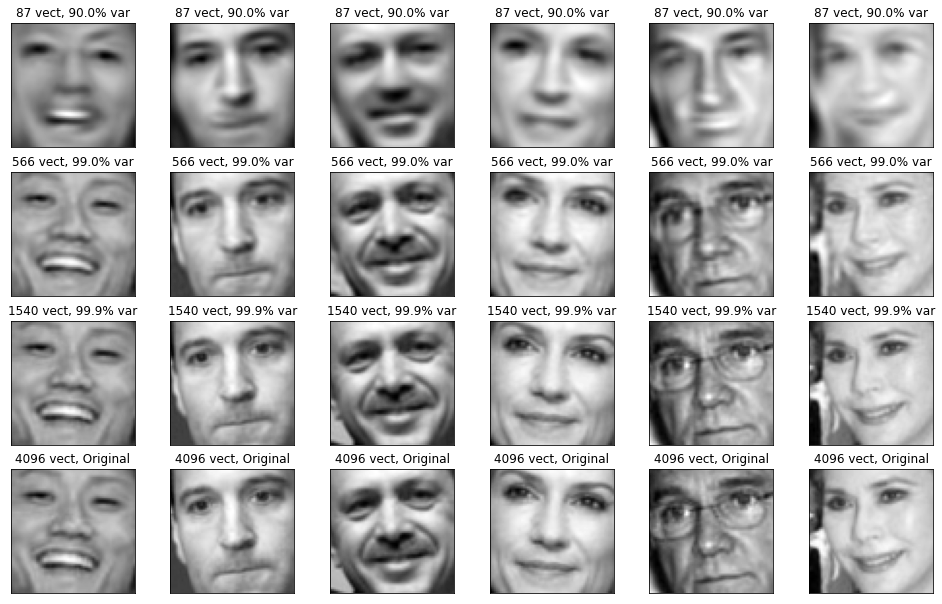

In [8]:
prop_vars = [0.90, 0.99, 0.999]
images = np.empty((0,4096))
labels = []

for prop_var in prop_vars:
    ef = Eigenfaces(prop_var_retained = prop_var)
    
    ef.fit(X[0:TRAIN_SIZE])

    images = np.concatenate((images, ef.project(X[0:6])))
    string = str(len(ef.basis)) + " vect, " + str(prop_var * 100) + "% var"
    labels = labels + ([string] * 6)

images = np.concatenate((images, X[0:6]))
labels = labels + (["4096 vect, Original"] * 6)

plot_images(images, titles = labels)

Above you can see 6 images from the dataset projected onto 3 different orthanormal bases of ${\rm I\!R}^{N^2}$.  These bases (eigenfaces) were calculated using 10,000 observations, but taking the time to compute with more is also possible.  The first orthonormal basis is chosen so that the eigenfaces saved retain 90% of the total variance of images in the dataset.  The second and third bases use the same method, but for 99% and 99.9% of the original variance.  By specifying these proportions of variance, we obtain bases for ${\rm I\!R}^{87}$, ${\rm I\!R}^{566}$, and ${\rm I\!R}^{1540}$.  We can see that the images get sharper with more eigenfaces, and by 1540 out of 4069 eigenfaces, we already have an almost indistinguishable projection.

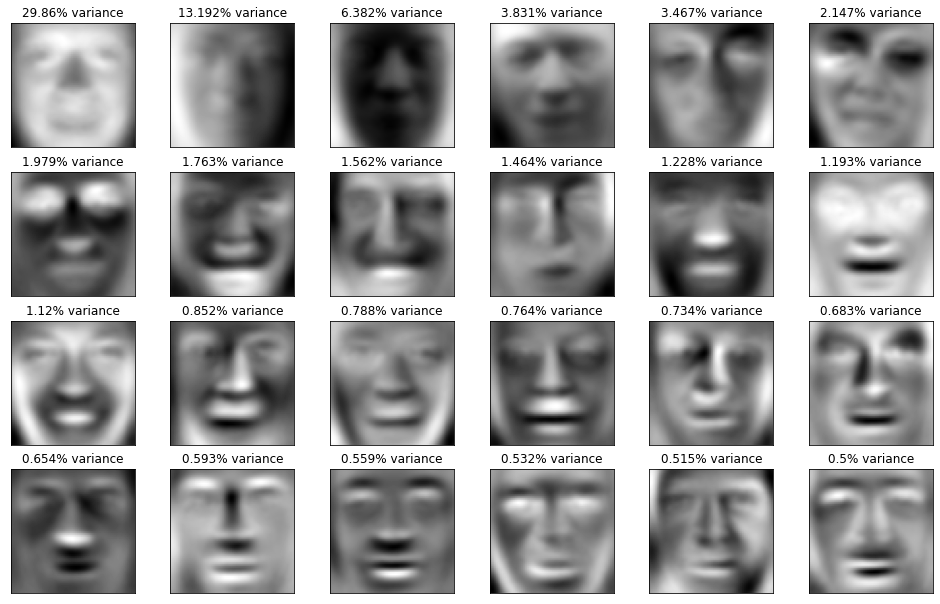

In [9]:
ef = Eigenfaces()
    
ef.fit(X[0:TRAIN_SIZE])

plot_images(ef.eigenvectors[ef.basis][0:24], 
            titles = [str(round(var*100,3)) + "% variance" for var in ef.var_props][0:24])

Plotted above is the first 24 eigenfaces calculated using 10,000 faces.  These images are the eigenvectors of the covariance matrix, sorted by their eigenvalue (variance).  Training with more face images will result in convergent eigenfaces.  For low numbers of training images, these eigenfaces are approximately noise.  We can see that each eigenface encodes unique (orthogonal) information to be used in a linear combination for a given image.  

For example, the first eigenface encodes general lighting, the second encodes horizontal lighting differences, and the third encodes background lighting.  Lighting is usually the cause of the most variation in images.  Some methods have shown that by removing the first couple of eigenfaces, we can project images onto a space that eliminates lighting variance, which is desireable for facial recognition **[[6]](#sources)**.  Other eigenfaces can encode specific features, such as glasses, sunglasses, facial hair, and more.

### Extensions

This method could be extended in many different ways.  For example, the first choice is to use this method on higher resolution images.  This would work because of our efficient computation of the eigenvectors of the covariance matrix.  This method could also be used on other objects that contain predictable features, such as animals, flowers, and possibly cars.

Another extension is to bring this problem into the field of multi-linear algebra.  By using tensors and other objects from that field, its possible to perform this decomposition for color images (a basis for each color channel), as well as perform this method without having to flatten images.  

## Data Reduction Analysis

Plot the cummulative variance retained as a function of the number of eigenvectors kept.  Plot the proportion variance that each eigenvector explains (eigenvalues).  Where is the elbow for good data reduction?

Define a loss metric between reconstructed images and their originals. Maybe this metric is the distance between the original image and the image projected into the face space.  Plot the average image loss as a function of the number of eigenvectors kept.

Save the reduced dataset to a csv file and compare the file size with the size of the original dataset.  Do this for several numbers of eigenvectors to plot the data loss as a function of the number of eigenvectors.

In [79]:
#https://www.google.com/search?q=python+find+size+of+file&rlz=1C1CHBF_enUS915US915&oq=python+find+size+of+file&aqs=chrome..69i57j35i39l2j0i20i263j0i433l5j46i433.5507j0j7&sourceid=chrome&ie=UTF-8

Discuss how this technology might be used in a database system.  How would inserts / deletes work?  When might we need to recalculate the eigenfaces?

## Machine Learning Demonstration

Discuss Turk and Pentland's 4 types of points, and how they translate to positives and negatives in the model.  Describe how Turk and Pentland's distance measurements can be genearlized to be used as a machine learning model.  Introduce the kNN model, and why it is a good choice for this problem.

Introduce research on this method by Ross Beveridge, and mention distance metrics, the selection of eigenvectors, and other results from Beveridge's paper.

Discuss how in general, PCA can be used as a dimension reduction technique and can eliminate the problem of multicolinearity.

Evaluate the performance of this implementation using Sci-kit Learn's kNN.  Use a GridSearch to test different parameters of kNN as well as what percentage of variance to retain in Eigenfaces.

In [48]:
num_images = 5000

X_train, X_test, y_train, y_test = train_test_split(X[0:num_images], y[0:num_images], train_size = 0.8, 
                                                    shuffle = True, random_state = RANDOM_SEED)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4000, 4096), (4000,), (1000, 4096), (1000,))

In [7]:
cross_validator = KFold(n_splits=5, shuffle=True, random_state = RANDOM_SEED)
score_method = "accuracy"

pipe = Pipeline([("ef", Eigenfaces()),
                 ("model", KNeighborsClassifier(metric="mahalanobis", 
                                                metric_params = {"V": np.cov(X_train, rowvar=False)}, 
                                                n_jobs = -1))])

params = {"ef__prop_var_retained": [0.95, 0.99, 0.999],
          "model__n_neighbors": [1,3]}

grid = GridSearchCV(pipe, params, cv=cross_validator, scoring=score_method, refit = False, n_jobs=-1, verbose=6)

In [8]:
grid.fit(X_train, y_train)

#model = grid.best_estimator_

grid.best_params_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  30 | elapsed: 10.2min remaining: 13.3min
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed: 10.3min remaining:  6.0min
[Parallel(n_jobs=-1)]: Done  25 out of  30 | elapsed: 12.9min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 12.9min finished


{'ef__prop_var_retained': 0.95, 'model__n_neighbors': 1}

In [11]:
model = Pipeline([("ef", Eigenfaces(prop_var_retained = 0.95)),
                 ("model", KNeighborsClassifier(n_neighbors = 1,
                                                metric="mahalanobis", 
                                                metric_params = {"V": np.cov(X_train, rowvar=False)}, 
                                                n_jobs = -1))])

model = model.fit(X_train, y_train)

ValueError: Mahalanobis dist: size of V does not match

In [ ]:
yhat = model.predict(X_test)

accuracy = accuracy_score(y_test, yhat)

accuracy

Compare these results to using kNN on the full images, not using Eigenfaces.  Consider time and performance.

Discuss how by colvolving this method around an image, we can determine regions where faces are in an image.  Our metric would be the distance to the face space.

Compare this method to modern facial recognition methods and why this might be an out dated method.

**Extra Credit:** Describe the distribution of distances between original images and their projected images.  Describe the distribution of distances between images and the mean face.  Describe the distribution of distances between images of a certain class and the mean face for that class.

# Sources

<a id='sources'></a>

Cite your sources. See Google Doc. Cite code.

[1] C. Sanderson, B.C. Lovell.
    Multi-Region Probabilistic Histograms for Robust and Scalable Identity Inference.
    ICB 2009, LNCS 5558, pp. 199-208, 2009.
    
[2] Turk, M.A., and A.P. Pentland. “Face Recognition Using Eigenfaces.” Proceedings. 1991 IEEE Computer Society Conference on Computer Vision and Pattern Recognition, 1991, doi:10.1109/cvpr.1991.139758. 

[3] Zhou, Tianjian. “Lecture 9 Principal Component Analysis.” STAT 460 - Applied Multivariate Analysis. STAT 460 - Applied Multivariate Analysis, 9 Mar. 2021, Fort Collins, CO, Colorado State University. 
    
[4] Li, Casey Juanxi. “PCA, Visualized for Human Beings.” Medium, Medium, 2 Aug. 2020, [medium.com/@sometimescasey/pca-visualized-for-human-beings-47d19a122734. ](https://medium.com/@sometimescasey/pca-visualized-for-human-beings-47d19a122734)

[5] Zabarauskas, Manfredas. “Eigenfaces Tutorial.” Manfred Zabarauskas' Blog, 2 Oct. 2009, [blog.manfredas.com/eigenfaces-tutorial/.](http://blog.manfredas.com/eigenfaces-tutorial/) 

[6] Yambor, Wendy S., et al. “Analyzing PCA-Based Face Recognition Algorithms: Eigenvector Selection and Distance Measures.” Series in Machine Perception and Artificial Intelligence, 2002, pp. 39–60., doi:10.1142/9789812777423_0003. 

[7] Acar, Nev. “Eigenfaces: Recovering Humans from Ghosts.” Medium, Towards Data Science, 2 Sept. 2018, [towardsdatascience.com/eigenfaces-recovering-humans-from-ghosts-17606c328184.](https://towardsdatascience.com/eigenfaces-recovering-humans-from-ghosts-17606c328184)